<div align='center'><h1> CS306 : Data Analysis and Visualization </h1>
    


    
<div align='center'>Riddhi Tanna

<div align='center'>201801427

---

> **Big Data Regression Analysis**: 
> In this lab, we perform ordinary least squares regression and bi-weighted robust least squares regression. We also find the 95% confidence interval for the value of the slope of the regression line that we obtain. 
We take two features from the given dataset: Distance and Air Time. 

# Ordinary Least Squares Regression

In [283]:
# importing the required libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import math
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt

## Defining functions for linear regression and root mean squared error (RMSE)

RMSE = sqrt(mean(squared errors/residuals))

In [355]:
def lin_regression(X, Y, n):
    sum_xy = 0
    for i in range(n):
        sum_xy = sum_xy + X[i]*Y[i]
    sum_x = X.sum()
    sum_y = Y.sum()
    sum_x_sq = 0
    for i in range(n):
        sum_x_sq = sum_x_sq + X[i]**2
    slope = (n*sum_xy - sum_x*sum_y)/(n*(sum_x_sq) - sum_x**2)
    intercept = (sum_y - slope*sum_x)/n
    return slope, intercept

def rmse_manual(Y, Y_pred, n):
    sum_diff = 0
    for i in range(n):
        sum_diff = pow((Y[i] - Y_pred[i]),2)
        
    std_err = math.sqrt(sum_diff.mean())
    return std_err

## Loading and normalizing data

In [284]:
# reading the data
df = pd.read_csv('/Users/riddhi/Downloads/2008.csv')

In [474]:
# filling up null values with the mean
distance = (df['Distance'].fillna(df['Distance'].mean()))
airtime = (df['AirTime'].fillna(df['AirTime'].mean()))

In [449]:
# mean normalizing the two features
dist_norm = pd.DataFrame((distance - distance.mean()))
airtime_norm =  pd.DataFrame((airtime - airtime.mean()))

## Finding the correlation coefficient

In [460]:
r = np.corrcoef(distance, airtime)[0][1]
print('Correlation Coefficient for Distance and AirTime : {}'.format(r))

Correlation Coefficient for Distance and AirTime : 0.9739459935679836


We can see that the two features have a high Pearson correlation coefficient, suggesting that there is a strong linear relation between the two. Hence, we will find the regression lines.

## Performing OLS regression
We have taken 20,000 samples from the given data and we will perform regression on them.

In [498]:
# define x and y for linear regression - x is the independent and y is the dependent
x = dist_norm['Distance'][:20000]
y = airtime_norm['AirTime'][:20000]
n = len(x)

In [462]:
# performing linear regression - returns slope and intercept
slope_manual, intercept_manual = lin_regression(x, y, n)

In [463]:
# using in-built library for linear regression to confirm values obtained from manual function
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print(slope,slope_manual)
print(intercept, intercept_manual)

0.11897115866937277 0.11897115866937127
-0.18867883190398338 -0.18867883190413412


In [506]:
# predicted values of y `
y_predict = x*slope_manual+intercept_manual
# calculating the rmse
print('RMSE for OLS : {}'.format(rmse_manual(y,y_predict,len(x))))

RMSE for OLS : 2.8674203808249814


## Plot - regression line and scatter plot: Distance vs. AirTime

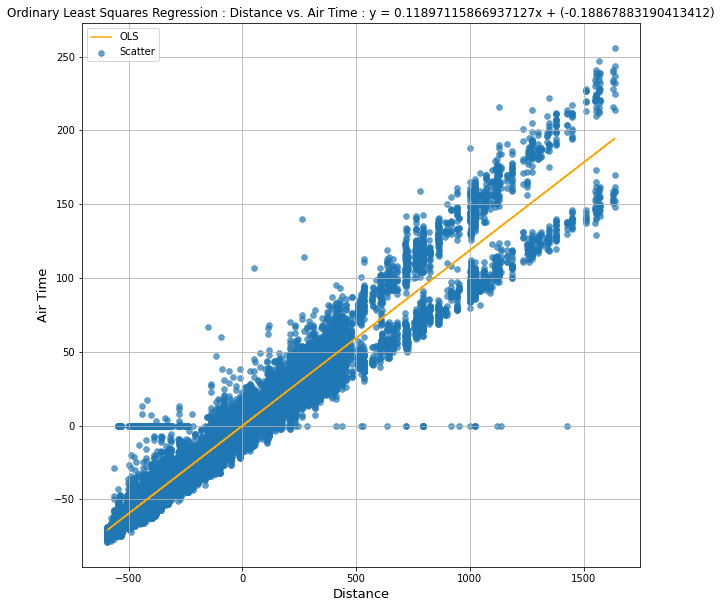

In [465]:
# plotting the scatter plot and the OLS regression line
fig, ax = plt.subplots(figsize=[10,10])

plt.grid()
plt.scatter(x, y, label='Scatter', lw=0.5, alpha = 0.7)
plt.plot(x,y_predict, label=('OLS'), color='orange')
plt.xlabel('Distance', fontsize = 13)
plt.ylabel('Air Time', fontsize = 13)
plt.title('Ordinary Least Squares Regression : Distance vs. Air Time : y = {}x + ({})'.format(slope_manual, intercept_manual))
plt.legend()

# 95 percent confidence interval of slope

In [485]:
# z-score for 95% CI
z_score = 1.96 
# standard error = standard deviation / sqrt(n)
std_err = (np.std(y)/np.std(x))/math.sqrt(n) 
# margin of error 
ME =  z_score*std_err 
upper_bound = slope_manual + ME 
lower_bound = slope_manual - ME
print('95% Confidence Interval for the slope is : [{},{}].'.format(lower_bound, upper_bound))
print('Our slope is : {}'.format(slope_manual))

95% Confidence Interval for the slope is : [0.11726542105869338,0.12067689628004917].
Our slope is : 0.11897115866937127


In [500]:
# computing the mean of y at x = 1200 
# Note that at x = 1200, we need to first normalize it since we are working with normalized data 
# Normalizing: 
x_norm = (1200 - distance[:20000].mean())/np.std(distance[:20000])
y_norm = slope_manual*x_norm + intercept
# standard error for y
std_err_y = np.std(y)/math.sqrt(len(y)) 

# margin of error
ME_y = z_score*std_err_y 

# lower bound
y_ub = y_norm + ME_y

#upper bound
y_lb = y_norm - ME_y

# mean of interval - adding mean of airtime because we have been working with mean normalized data
y_mean = np.array([y_lb,y_ub]).mean() + airtime[:20000].mean()
print('Mean of y at x = 1200: {}'.format(y_mean))

Mean of y at x = 1200: 91.70560264294663


# Bi-weighted Robust Least Squares Regression

## Function for bi-weighted robust least squares regression 

In [502]:
def wls_regression(X, Y, n):
    slopes = np.zeros(n)
    intercepts = np.zeros(n)
    slopes[0], intercepts[0] = lin_regression(X,Y,n)
    y_pred = X*slopes[0] + intercepts[0]
    slope_current = slopes[0]
    slope_prev = 0
    threshold = 0.0000001
    i = 1
    while(abs(slope_current  - slope_prev)>threshold):
        u = np.zeros(n)
        w = np.zeros(n)
        d = np.zeros(n)
        #calculating weights
        for l in range(n):
            d[i] = (Y[l] - y_pred[l])
        for j in range(n):
            u[j] = d[j]/(3*np.std(d))
            if(u[j]>1):
                w[j] = 0
            else:
                w[j] = pow( (1 - pow(u[j],2) ) , 2)
            
        num_s = 0 
        den_s = 0 
        for k in range(n):
            num_s = num_s + w[k]*X[k]*Y[k]
            den_s = den_s + w[k]*X[k]*X[k]
            
        #updating slope
        slopes[i] = num_s/den_s
        
        y_wmean = 0
        x_wmean = 0
        for a in range(n):
            y_wmean = y_wmean + w[a]*Y[a]
            x_wmean = x_wmean + w[a]*X[a]
        y_wmean = y_wmean/sum(w)
        x_wmean = x_wmean/sum(w)
        
        #updating intercept
        intercepts[i] = y_wmean - slopes[i]*x_wmean
        
        slope_prev = slope_current
        slope_current = slopes[i]
        intercept_current = intercepts[i]
        
        #updating y_pred
        y_pred = slope_current*x + intercept_current
        i = i + 1
 
    
    return slope_current, intercept_current

In [503]:
slope_wls, intercept_wls = wls_regression(x,y,len(x))

In [504]:
y_pred = slope_wls*x + intercept_wls

In [505]:
print('RMSE for WLS: {}'.format(rmse_manual(y,y_pred,n)))

RMSE for WLS: 0.9223165736716581


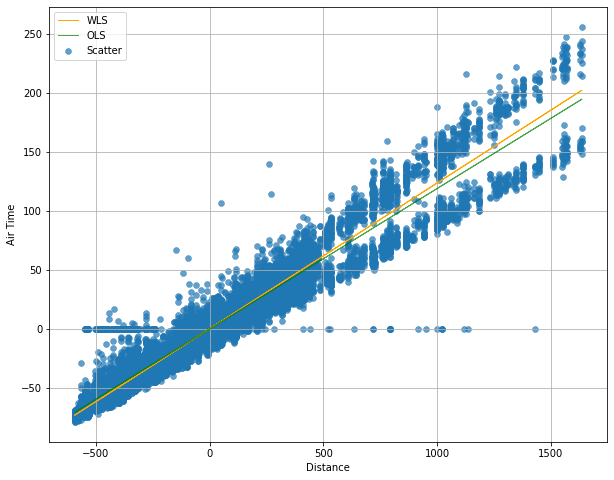

In [443]:
# plotting the scatter plot and the OLS regression line
fig, ax = plt.subplots(figsize=[10,8])

plt.grid()
# plotting
plt.scatter(x, y, label='Scatter', lw=0.5, alpha = 0.7)
plt.plot(x,y_pred, label=('WLS'), color='orange', lw=1)
plt.plot(x,y_predict, label=('OLS'), color='green', alpha=0.7, lw=1)
plt.xlabel('Distance')
plt.ylabel('Air Time')
plt.legend()

# Conclusions

We can see that implementation of the bi-weighted robust least squares regression has a smaller value of RMSE, indicating that it is a better fit for our data. This happens because WLS is more robust as it is less tolerant towards outliers. We give each of the data points a weight according to how far away they lie from the the actual data point. We calculate the ratio of the deviation of predicted y from the actual y and a constant (here, 3) times the standard deviation. If this ratio is more than 1, we give the data point a weight of zero. This means that any data point lying more than 3 standard deviations of y away from the actual data point is disregarded. In essence, we disregard outliers by giving them less (or zero) weight. 

Such a regression can be useful when we have data whose variance is not constant. In such cases, we probably have more outliers that we may want to disregard because they might end up giving us wrong estimates about what is the best fit for the majority of the data. 